# Langchain

In [17]:
%pip install -q python-dotenv langchain-openai


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
from dotenv import load_dotenv

load_dotenv()

True

`ChatOpenAI`에는 `api_key` 파라미터가 존재하지만, 환경 변수에 지정된 변수명으로 `api_key`를 정의하면 자동으로 할당된다.
이는 Anthropic, Groq, Ollama, Azure OpenAI 등 다른 모델에도 동일하게 적용된다.

In [19]:
from langchain_openai import ChatOpenAI

query = "2019년 챔피언스리그는 어떤 팀이 우승했어?"

llm = ChatOpenAI(model="gpt-4o-mini")
llm.invoke(query)

AIMessage(content='2019년 UEFA 챔피언스리그에서 우승한 팀은 리버풀 FC입니다. 리버풀은 결승에서 토트넘 홋스퍼를 2-0으로 이기고 챔피언스리그 트로피를 차지했습니다. 이 경기는 2019년 6월 1일 스페인 마드리드의 메트로폴리타노 스타디움에서 열렸습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 26, 'total_tokens': 124, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-7917fd0e-8355-48b4-8031-06159003cf3c-0', usage_metadata={'input_tokens': 26, 'output_tokens': 98, 'total_tokens': 124, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Langgraph

### ✓ State 
현재 Agent의 상태
### ✓ Node 
Agent가 수행하는 작업
- Agent
- 함수
    - Agentic RAG : query -> retrieve -> generate
    - 여기서 retrieve, generate는 함수로 정의
### ✓ Edge
Node들의 관계 (다음 수행 노드)
### ✓ Conditional Edge
조건부 관계

In [20]:
%pip install -q langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


AnyMessage
- SystemMessage
- HumanMessage
- AIMessage

In [21]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class AgentState(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]]

In [22]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

In [23]:
def generate(state: AgentState) -> AgentState:
    messages = state["messages"]
    ai_message = llm.invoke(messages)
    return {"messages": [ai_message]}

graph_builder.add_node(generate, "generate")

In [24]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

`graph_builder.add_edge(START, "generate")`에서 "generate"를 따옴표로 감싸는 이유

1. **노드 식별자로서의 역할**: 
- `add_node()`에서 "generate"라는 이름으로 노드를 등록했기 때문에, `add_edge()`에서도 동일한 문자열로 해당 노드를 참조해야 한다.
- 이는 그래프 내에서 노드를 식별하는 고유한 문자열 식별자(string identifier)로 작동한다.

2. **함수와 노드 이름의 구분**:
- `generate`는 우리가 정의한 함수의 이름이지만, 그래프에서는 이 함수를 실행할 노드의 이름으로 "generate"를 사용한다.
- 따옴표로 감싸서 이것이 함수 자체가 아닌 노드의 이름임을 명확히 한다.

3. **그래프 구조의 명확성**:
- LangGraph는 내부적으로 이러한 문자열 식별자를 사용하여 그래프의 구조를 관리하고 노드 간의 연결을 추적한다.
- 문자열로 노드를 참조함으로써 그래프의 구조를 더 명확하게 표현하고 관리할 수 있다.

만약 따옴표 없이 `generate`를 사용하면, Python은 이를 함수 객체로 해석하려 할 것이고, 이는 LangGraph가 기대하는 노드 식별자 형식이 아니기 때문에 오류가 발생할 수 있다.



In [25]:
graph = graph_builder.compile()

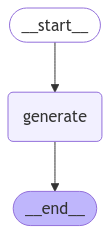

In [27]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### LangGraph의 실행 흐름
1. graph.invoke(state)로 그래프 실행
2. state는 딕셔너리 형태로 전달 (예: {"messages": [HumanMessage(...)]})
3. generate 노드가 state를 입력으로 받아서 처리
4. 각 노드는 state를 받아서 새로운 state를 반환하는 구조

In [28]:
from langchain_core.messages import HumanMessage

initial_state = {"messages": [HumanMessage(query)]}
graph.invoke(initial_state)

{'messages': [AIMessage(content='2019년 UEFA 챔피언스리그에서는 리버풀이 우승했습니다. 결승전에서 토트넘 홉스퍼를 2-0으로 이기고, 클럽 역사상 6번째 UEFA 챔피언스리그 우승을 차지했습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 26, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-7aa8219b-087c-4082-9ede-5ce3eb2cc16a-0', usage_metadata={'input_tokens': 26, 'output_tokens': 64, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

- LangGraph를 굳이 구현해야 하는지 잘 고민해보자.
- LangChain으로만 구현해도 충분할 수 있다.